In [25]:
import numpy as np
import math
import nibabel as nib
import cv2
from skimage import measure
from skimage import morphology
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.spatial import ConvexHull

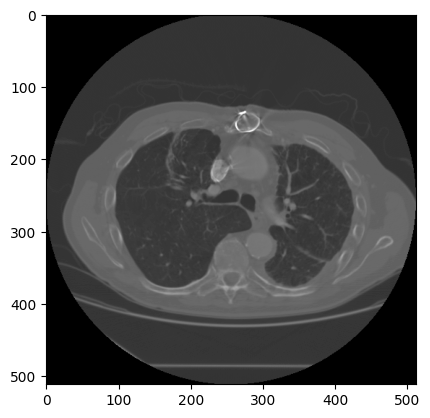

In [26]:
fname = './Images/IMG_0011.nii.gz'

foo = nib.load(fname).get_fdata()

plt.imshow(foo[:,:,100],cmap='gray')

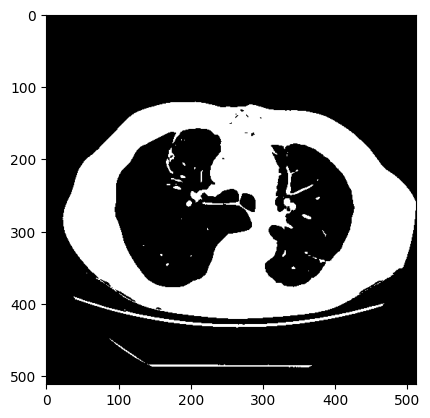

In [27]:
# run binarization with treshold HU = -320
binary_image = np.where(foo < -320, 0, 1)
plt.imshow(binary_image[:,:,100],cmap='gray')

In [28]:
def get_body_mask(foo):
    body_mask = np.array(foo)
    for i in range(0,foo.shape[2]):
        # Remove small objects (air bubbles and noise) using morphological opening
        cleaned_image = morphology.remove_small_objects(binary_image[:,:,i].astype(bool), min_size=500)

        # Fill holes inside the binary mask
        filled_image = ndimage.binary_fill_holes(cleaned_image)

        # Label connected components
        labels = measure.label(filled_image)

        # Find the largest component (the body)
        props = measure.regionprops(labels)
        props = sorted(props, key=lambda x: x.area, reverse=True)

        # Create an empty mask and fill it with the largest region (body)
        body_mask[:,:,i] = np.zeros_like(labels)
        body_mask[:,:,i][labels == props[0].label] = 1
        body_mask[:,:,i] = cv2.erode(body_mask[:,:,i].astype(np.uint8), cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2)))

    # Display the final segmented body image
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(foo[:,:,50], cmap='gray')
    ax[0].set_title("Original Image")
    ax[1].imshow(body_mask[:,:,50], cmap='gray')
    ax[1].set_title("Segmented body")
    plt.title("Segmented body")
    plt.show()

    return body_mask

In [29]:
def get_lung_mask(foo):
    lung_mask = np.array(foo)

    for i in range(0,foo.shape[2]):
        # Remove small objects (air bubbles and noise) using morphological opening
        cleaned_image = morphology.remove_small_objects(binary_image[:,:,i].astype(bool), min_size=500)

        # Invert image
        cleaned_image = np.where(cleaned_image == 0, 1, 0)
        cleaned_image = cv2.erode(cleaned_image.astype(np.uint8), cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)))
        labels = measure.label(cleaned_image)

        # Find the largest two components (the lungs)
        props = measure.regionprops(labels)
        props = sorted(props, key=lambda x: x.area, reverse=True)

        # Create an empty mask and fill it with the two largest regions (lungs)
        lung_mask[:,:,i] = np.zeros_like(labels)
        for prop in props[1:3]:
            lung_mask[:,:,i][labels == prop.label] = 1
            lung_mask[:,:,i] = cv2.dilate(lung_mask[:,:,i].astype(np.uint8), cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))
            lung_mask[:,:,i] = cv2.morphologyEx(lung_mask[:,:,i], cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)))

        #label the right and left lung
        right_lung = np.zeros_like(labels)
        left_lung = np.zeros_like(labels)
        for prop in props[1:3]:
            if prop.centroid[1] > foo.shape[1] / 2:
                right_lung[labels == prop.label] = 1
            else:
                left_lung[labels == prop.label] = 1

        lung_mask[:,:,i] = right_lung + left_lung

    return lung_mask


In [30]:
from sklearn import cluster
from skimage.segmentation import watershed
from scipy.ndimage import distance_transform_edt

def __kmeans_clusterization(img: np.ndarray, n_clusters: int):
    markers = np.stack(np.where(img > 0), axis=-1)

    clusters = cluster.KMeans(n_clusters=n_clusters, random_state=0)
    points = clusters.fit_predict(X=markers)

    return points, clusters.cluster_centers_

def watershed_segmentation(img: np.ndarray, kmeans_centers):
    markers = np.zeros(img.shape, dtype=np.int32)

    for i, center in enumerate(kmeans_centers):
        cnter_int = tuple(np.round(center).astype(int))


        if 0 <= cnter_int[0] < img.shape[0] and 0 <= cnter_int[1] < img.shape[1] and 0 <= cnter_int[2] < img.shape[2]:
            markers[cnter_int] = i + 1

    distance = distance_transform_edt(img)
    return watershed(-distance, markers, mask=img)

In [31]:
from surface_distance import metrics

def evaluate_segmentation(lung_mask, ref):
    # Compute surface distances
    dice_coefficient = metrics.compute_dice_coefficient(lung_mask.astype(bool), ref.astype(bool))
    distance = metrics.compute_surface_distances(lung_mask.astype(bool), ref.astype(bool), spacing_mm=(1, 1, 1))
    hausdorff_distance = metrics.compute_robust_hausdorff(distance, 95)

    return dice_coefficient, hausdorff_distance

In [32]:
import os
import nibabel as nib
import numpy as np

coefficients_right_lung = []
dist_right_lung = []
coefficients_left_lung = []
dist_left_lung = []
coefficients_body = []
dist_body = []

def swap_labels(lung_mask, centroids, right_label=1, left_label=2):
    # Swap labels if the first centroid is in the left lung
    print(lung_mask[centroids[0][0]][centroids[0][1]][centroids[0][2]])
    if lung_mask[centroids[0][0]][centroids[0][1]][centroids[0][2]] == left_label:
        print("Swapping labels")

    return lung_mask
def get_lungs_from_labels(lung_mask, right_label=1, left_label=2):
    """Extract right and left lung masks based on labels."""
    right_lung_mask = (lung_mask == right_label).astype(np.uint8)  # Right lung based on label
    left_lung_mask = (lung_mask == left_label).astype(np.uint8)    # Left lung based on label
    return right_lung_mask, left_lung_mask

for file in os.listdir('./Images/'):
    if file.endswith('.nii.gz'):
        fname = './Images/' + file
        foo = nib.load(fname).get_fdata()

        # Thresholding for lung segmentation
        binary_image = np.where(foo < -320, 0, 1)

        body_mask = get_body_mask(foo)
        lung_mask = get_lung_mask(foo)

        _, centroids = __kmeans_clusterization(lung_mask, 2)
        lung_mask = watershed_segmentation(lung_mask, centroids)
        print(centroids)

        # Load labeled reference segmentation for lungs
        ref_lungs = nib.load('./ReferenceSegmentations/LUNGS_' + file).get_fdata()
        
        # Display the original image, reference and pred segmentation
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(foo[:,:,50], cmap='gray')
        ax[0].set_title("Original Image")
        ax[1].imshow(ref_lungs[:,:,50], cmap='gray')
        ax[1].set_title("Reference Segmentation")
        ax[2].imshow(lung_mask[:,:,50], cmap='gray')
        ax[2].set_title("Predicted Segmentation")
        plt.show()

        # Extract right and left lungs from labeled reference (e.g., label 1 = right, label 2 = left)
        ref_right_lung, ref_left_lung = get_lungs_from_labels(ref_lungs, right_label=3, left_label=2)

        # Extract predicted right and left lungs from the segmented mask
        if centroids[0][1] > centroids[1][1]:
            pred_right_lung, pred_left_lung = get_lungs_from_labels(lung_mask, right_label=1, left_label=2)
        else:
            pred_right_lung, pred_left_lung = get_lungs_from_labels(lung_mask, right_label=2, left_label=1)
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        ax[0, 1].imshow(ref_right_lung[:,:,50], cmap='gray')
        ax[0, 1].set_title("Reference Right Lung")
        ax[0, 0].imshow(ref_left_lung[:,:,50], cmap='gray')
        ax[0, 0].set_title("Reference Left Lung")
        ax[1, 1].imshow(pred_right_lung[:,:,50], cmap='gray')
        ax[1, 1].set_title("Predicted Right Lung")
        ax[1, 0].imshow(pred_left_lung[:,:,50], cmap='gray')
        ax[1, 0].set_title("Predicted Left Lung")
        plt.show()

        # Evaluate right lung
        dice_coefficient, hausdorff_distance = evaluate_segmentation(pred_right_lung, ref_right_lung)
        coefficients_right_lung.append(dice_coefficient)
        dist_right_lung.append(hausdorff_distance)
        print("Dice coefficient for right lung: ", dice_coefficient)
        print("Hausdorff distance for right lung: ", hausdorff_distance)

        # Evaluate left lung
        dice_coefficient, hausdorff_distance = evaluate_segmentation(pred_left_lung, ref_left_lung)
        coefficients_left_lung.append(dice_coefficient)
        dist_left_lung.append(hausdorff_distance)
        print("Dice coefficient for left lung: ", dice_coefficient)
        print("Hausdorff distance for left lung: ", hausdorff_distance)

        # Load reference for body mask
        ref_body = nib.load('./BodyMasks/BODYMASK_' + file).get_fdata()
        ref_body = (ref_body > 0).astype(np.uint8)

        # Evaluate body mask
        dice_coefficient, hausdorff_distance = evaluate_segmentation(body_mask, ref_body)
        coefficients_body.append(dice_coefficient)
        dist_body.append(hausdorff_distance)
        print("Dice coefficient for body: ", dice_coefficient)
        print("Hausdorff distance for body: ", hausdorff_distance)

# Print results for right and left lung and body
print("Mean Dice coefficient for right lung: ", np.mean(coefficients_right_lung))
print("Mean Hausdorff distance for right lung: ", np.mean(dist_right_lung))
print("Mean Dice coefficient for left lung: ", np.mean(coefficients_left_lung))
print("Mean Hausdorff distance for left lung: ", np.mean(dist_left_lung))

print("Mean Dice coefficient for body: ", np.mean(coefficients_body))
print("Mean Hausdorff distance for body: ", np.mean(dist_body))

KeyboardInterrupt: 